In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from src.attribution.flextime.filterbank import Filterbank

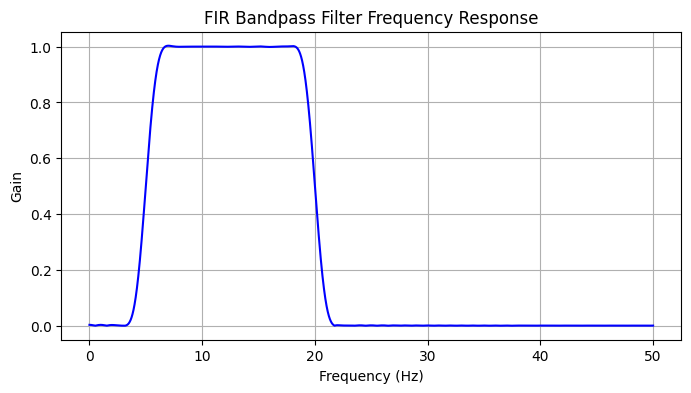

In [2]:
def fir_bandpass_filter(num_taps, lowcut, highcut, fs):
    """
    Generates a FIR bandpass filter using the windowed sinc method.
    
    Parameters:
    - num_taps (int): Length of the filter (should be odd for best symmetry).
    - lowcut (float): Lower cutoff frequency (Hz).
    - highcut (float): Upper cutoff frequency (Hz).
    - fs (float): Sampling frequency (Hz).
    - window (str): Window function (default is 'hamming').

    Returns:
    - h (numpy array): Filter coefficients.
    """

    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design FIR bandpass filter
    h = signal.firwin(num_taps, [low, high], pass_zero=False)

    return h

# Example usage
fs = 100        # Sampling frequency in Hz
num_taps = 101  # Filter length (must be odd for symmetry)
lowcut = 5      # Lower cutoff frequency in Hz
highcut = 20    # Upper cutoff frequency in Hz

h = fir_bandpass_filter(num_taps, lowcut, highcut, fs)

# Plot frequency response
w, h_response = signal.freqz(h, worN=8000)
plt.figure(figsize=(8, 4))
plt.plot((fs * 0.5 / np.pi) * w, np.abs(h_response), 'b')
plt.title("FIR Bandpass Filter Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.grid()
plt.show()

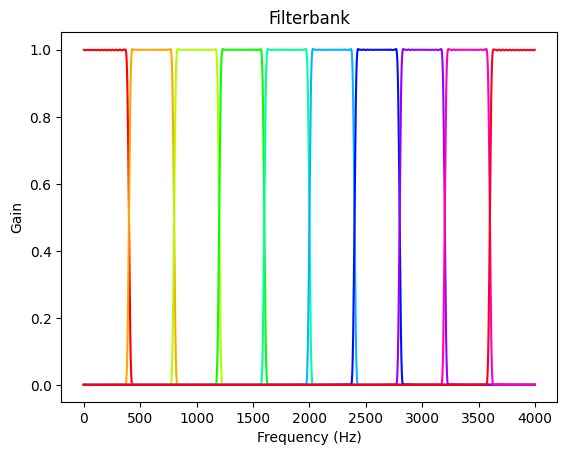

In [3]:
num_taps = 501      # how sharp the filter is (squaredness)
n_filters = 10      # number of filters
sample_freq = 8000  # changes x axis
bandwidth = 400     # changes bandwidth of each filter

filterbank = Filterbank(num_taps, n_filters, sample_freq, bandwidth)

# Plot frequency responses
filterbank.plot_filterbank()

In [4]:
# load sleepedf data for testing
from physioex.physioex.data import PhysioExDataModule

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],
    batch_size=1,
    preprocessing="raw",
    selected_channels=["EEG"],
    sequence_length=7,
    data_folder="./data"
)

print(datamodule)

test_loader = datamodule.test_dataloader()
print(len(test_loader))

{Train dataloader: size=131042}
{Validation dataloader: size=36612}
{Test dataloader: size=26322}
{Predict dataloader: None}
26322


In [5]:
# apply the filterbank to the first batch
for batch in test_loader:

    x, y = batch
    x = x.squeeze(0).numpy() # shape (N, C, T) - num sequences, num channels, samples per sequence (30s * 100Hz)
    y = y.squeeze(0).numpy()

    print(x.shape)
    print(y.shape)

    # Apply the filterbank to the data
    filtered_data = filterbank.apply_filterbank(x)

    break

(7, 1, 3000)
(7,)


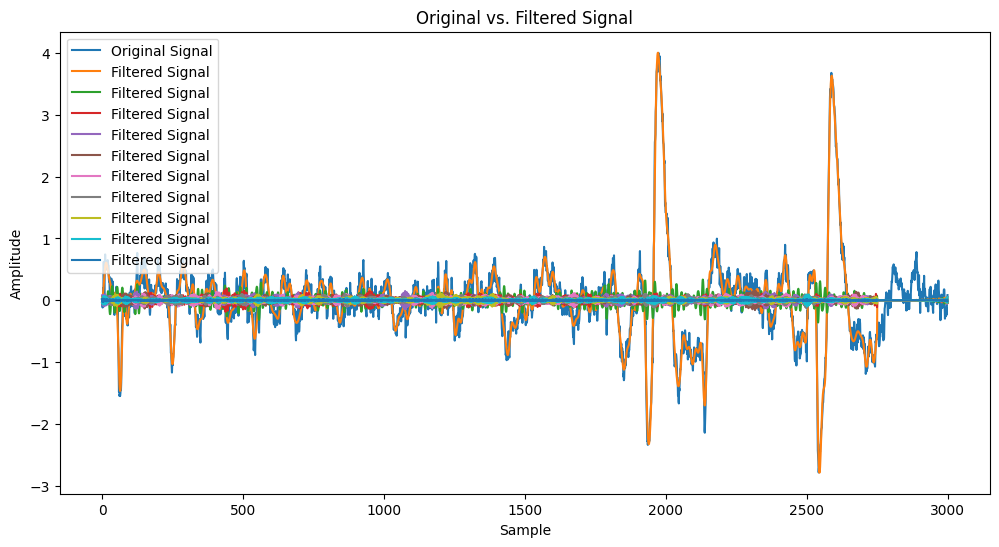

In [6]:
# Plot the original and filtered signals first 30s window of the first sequence
plt.figure(figsize=(12, 6))
plt.plot(x[0][0], label="Original Signal")
plt.plot(filtered_data[0][0], label="Filtered Signal")
plt.title("Original vs. Filtered Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend(loc="upper left")
plt.show()

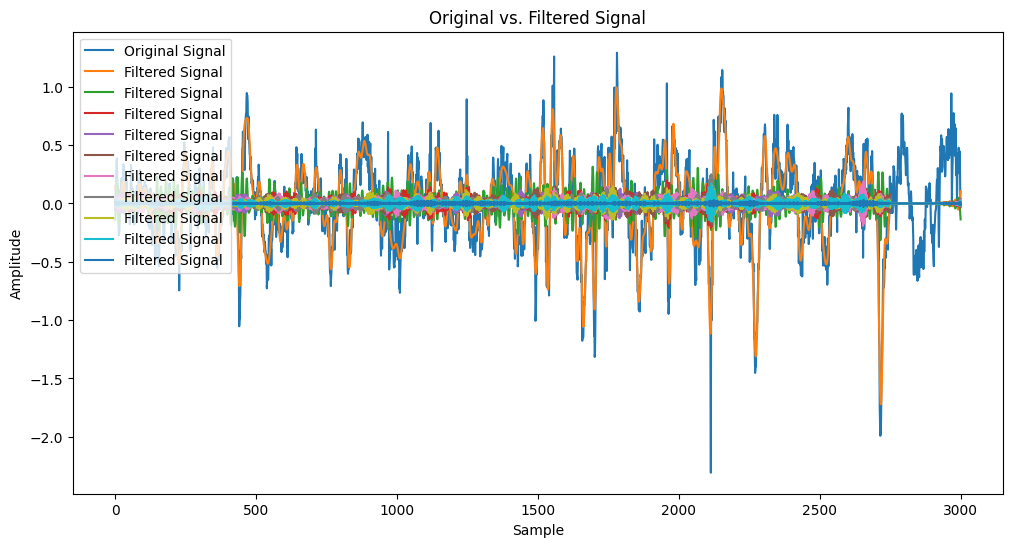

In [8]:
# Plot the original and filtered signals first 30s window of the second sequence
plt.figure(figsize=(12, 6))
plt.plot(x[1][0], label="Original Signal")
plt.plot(filtered_data[1][0], label="Filtered Signal")
plt.title("Original vs. Filtered Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend(loc="upper left")
plt.show()

In [22]:
# simulate data
import numpy as np
import matplotlib.pyplot as plt
from src.data_gen import generate_signal

num_samples = 10  # Number of samples per class
# Parameters
fs = 100  # Sampling rate
T = 30      # Duration in seconds
N = fs * T # Number of samples
t = np.linspace(0, T, N)

samples_0 = [generate_signal([5, 20], [7, 21], [1, 0.7], fs=fs, T=T) for _ in range(num_samples)]
samples_1 = [generate_signal([20, 5], [7, 21], [1, 0.7], fs=fs, T=T) for _ in range(num_samples)]


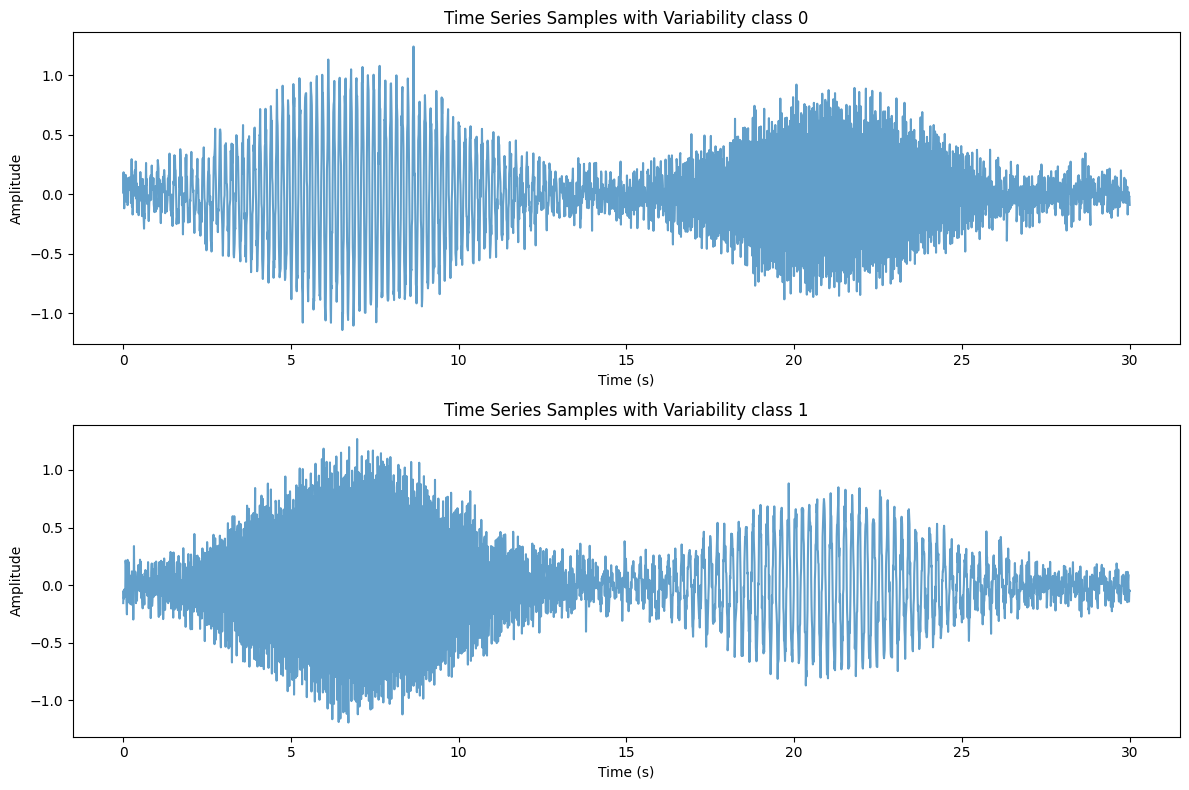

In [26]:
# Plot some samples
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
for i in range(1):  # Show three samples per class
    axs[0].plot(t, samples_0[i], alpha=0.7)
    axs[1].plot(t, samples_1[i], alpha=0.7)

axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Time Series Samples with Variability class 0")

axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Time Series Samples with Variability class 1")

fig.tight_layout()
plt.show()